## Content:

1. [Necessary Libraries](#1)
2. [Defining Model](#2)
3. [Defining Data](#3)
4. [Training the Model](#4)
5. [Prediction](#5)
6. [Prediction on Single Image](#6)
    

## Necessary Libraries
<a id = '1'></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import Image

import os
import shutil
import random
import itertools
import matplotlib.pyplot as plt

### GPU Control

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Defining Model
<a id = '2'></a>

In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________

In [4]:
x = mobile.layers[-6].output
#output unit number should be equal to the number of classes
output = Dense(units=4, activation='softmax')(x) 
model = Model(inputs=mobile.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

### Reducing the number of parameters

This fine-tuning step is optional. You can skip it. To learn about training parameter you can visit [keras](https://keras.io/guides/transfer_learning/)

<b>Note: </b>Setting trainable = False prevents updating weights, not training.

In [5]:
#Last 23 layer will be non-trainable
for layer in model.layers[:-23]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

## Defining Data
<a id = '3'></a>

#### CT KIDNEY DATASET: Normal-Cyst-Tumor and Stone

The dataset was collected from PACS (Picture Archiving and Communication System) from different hospitals in Dhaka, Bangladesh, where patients had already been diagnosed with kidney tumor, cyst, normal or stone findings. Both Coronal and Axial cuts include both contrast and non-contrast studies with the protocol for the entire abdomen and urogram.

The classes are as follows:
* Cyst
* Normal
* Stone
* Tumor

You can find the dataset and more information [here](https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone).

In [6]:
# Organize data into train, valid, test dirs (split: %75-15-10)
DIR_MAIN = 'your dataset path/'
DIR_TARGET= 'your organized dataset path/'


# list of labels
labels = os.listdir(DIR_MAIN)
for label in labels:
    os.makedirs(DIR_TARGET +'/train/' + label)
    os.makedirs(DIR_TARGET +'/val/' + label)
    os.makedirs(DIR_TARGET +'/test/' + label)

    src = DIR_MAIN + label
    files = os.listdir(src)
    
    np.random.shuffle(files)
    train_files, val_files = np.split(np.array(files),[int(len(files)*0.75)])
    val_files, test_files = np.split(np.array(val_files),[int(len(files)*0.15)])
    
    train_files = [src+'/'+ name for name in train_files]
    val_files = [src+'/' + name for name in val_files]
    test_files = [src+'/' + name for name in test_files]
    
    print('Class: ', label)
    print('Total images: ', len(files))
    print('Training: ', len(train_files))
    print('Validation: ', len(val_files))
    print('Test: ', len(test_files))

    for name in train_files :
        shutil.copy(name, DIR_TARGET+'/train/'+label)

    for name in val_files:
        shutil.copy(name, DIR_TARGET+'/val/'+label)
    
    for name in test_files:
        shutil.copy(name, DIR_TARGET+'/test/'+label)

Class:  Cyst
Total images:  3700
Training:  2775
Validation:  555
Test:  370
Class:  Normal
Total images:  5060
Training:  3795
Validation:  759
Test:  506
Class:  Stone
Total images:  1360
Training:  1020
Validation:  204
Test:  136
Class:  Tumor
Total images:  2280
Training:  1710
Validation:  342
Test:  228


In [7]:
def prepare_image(file):
    img_path = 'your organized dataset path/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [8]:
train_path = DIR_TARGET + 'train/'
val_path = DIR_TARGET + 'val/'
test_path = DIR_TARGET 'test/'

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=32)
val_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=val_path, target_size=(224,224), batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 9300 images belonging to 4 classes.
Found 1860 images belonging to 4 classes.
Found 1240 images belonging to 4 classes.


## Training
<a id = '4'></a>

In [14]:
epoch_num = 100
es = EarlyStopping(monitor='val_acc', mode='auto', restore_best_weights=True, verbose=1, patience=3)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=val_batches,
            validation_steps=len(val_batches),
            epochs=epoch_num,
            callbacks=[es],
            verbose=1
)

Epoch 1/100
291/291 [==============================] - 66s 226ms/step - loss: 0.0090 - acc: 0.9991 - val_loss: 1.1799 - val_acc: 0.5038
Epoch 2/100
291/291 [==============================] - 65s 222ms/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.6073 - val_acc: 0.7495
Epoch 3/100
291/291 [==============================] - 63s 217ms/step - loss: 6.9184e-04 - acc: 1.0000 - val_loss: 0.6616 - val_acc: 0.7263
Epoch 4/100
291/291 [==============================] - 69s 236ms/step - loss: 5.9978e-04 - acc: 1.0000 - val_loss: 1.1855 - val_acc: 0.5613
Epoch 5/100
291/291 [==============================] - 73s 250ms/step - loss: 0.0034 - acc: 0.9990 - val_loss: 3.0133 - val_acc: 0.4516
Epoch 00005: early stopping


In [15]:
#save model
model_path = 'name the model with extension .h5'
model.save(model_path)
# load model
# model = model.load_model(model_path)

## Training History

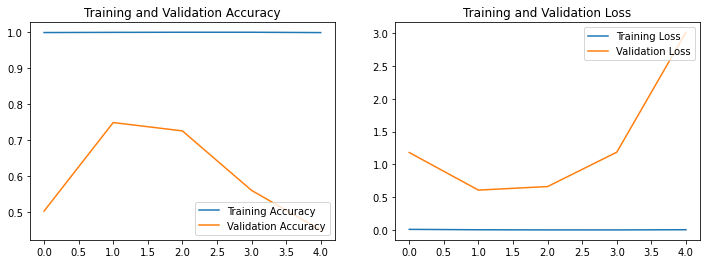

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

#if early stopping method is used epochs_range should be arrenged as epoch number when early stopping occurs
epochs_range = range(5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction
<a id = '5'></a>

In [17]:
test_labels = test_batches.classes
pred_test = np.argmax(model.predict(x=test_batches, steps=len(test_batches), verbose=1), axis=1)
print(classification_report(test_labels, pred_test, target_names=labels,digits=4))

39/39 [==============================] - 7s 180ms/step
              precision    recall  f1-score   support

        Cyst     0.8943    0.8000    0.8445       370
      Normal     0.9819    0.6443    0.7780       506
       Stone     0.3747    1.0000    0.5451       136
       Tumor     0.7944    0.7456    0.7692       228

    accuracy                         0.7484      1240
   macro avg     0.7613    0.7975    0.7342      1240
weighted avg     0.8547    0.7484    0.7707      1240



In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


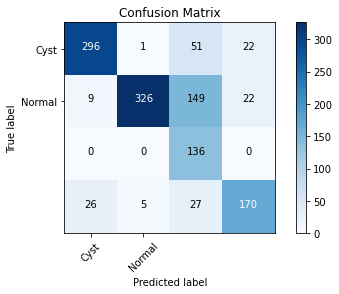

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=pred_test)
cm_plot_labels = ['Cyst','Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Prediction on Single Image
<a id = '6'></a>

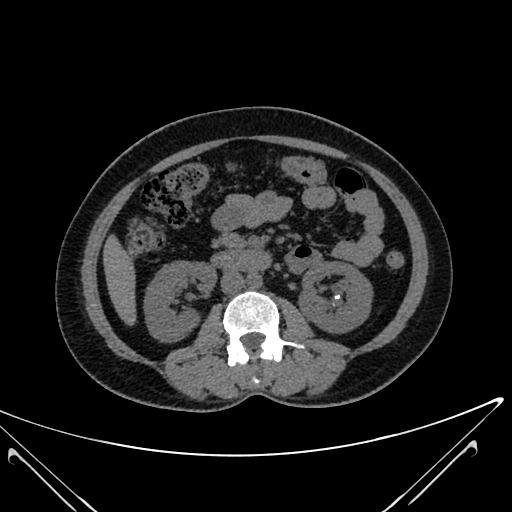

In [22]:
Image(filename='type any file path', width=300,height=200)

In [27]:
preprocessed_image = prepare_image('type same file path here')
predictions = model.predict(preprocessed_image)

In [25]:
predictions

array([[0.00544217, 0.02393171, 0.9146273 , 0.05599872]], dtype=float32)